In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.append("..")

In [2]:
from src.model import VOEQwen2VLModel

ckpt_path = None
model = VOEQwen2VLModel("Qwen/Qwen2-VL-2B-Instruct", ckpt_path=ckpt_path, lora=False, use_flash_attn=False)
model.to("cuda:0")

/opt/conda/envs/modern/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
08/04/2025 16:38:58 - INFO - datasets -   PyTorch version 2.1.2 available.
08/04/2025 16:38:58 - INFO - datasets -   Polars version 1.25.2 available.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


VOEQwen2VLModel(
  (model): Qwen2VLForConditionalGeneration(
    (visual): Qwen2VisionTransformerPretrainedModel(
      (patch_embed): PatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2VLVisionBlock(
          (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
          (attn): VisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): VisionMlp(
            (fc1): Linear(in_features=1280, out_features=5120, bias=True)
            (act): QuickGELUActivation()
            (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          )
        )
      )
      (merger): PatchMerger(
        (ln_q): Lay

In [3]:
from PIL import Image
image_path1 = '../assets/Tesla_Cybertruck_Foundation_Series,_front_left_(Greenwich).jpg'
image_path2 = '../assets/Tesla_Cybertruck_damaged_window.jpg'
image_path3 = '../assets/1.png'

image1 = Image.open(image_path1).convert('RGB').resize((448,448))
image2 = Image.open(image_path2).convert('RGB').resize((448,448))
image3 = Image.open(image_path3).convert('RGB').resize((448,448))

instruction = "<|image_pad|> What kind of car is this?\nRepresent the given text/image in one word."

embs = model(texts=[instruction]*3, images=[image1, image2, image3])

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [4]:
embs @ embs.T

tensor([[1.0000, 0.9570, 0.9062],
        [0.9570, 0.9961, 0.8984],
        [0.9062, 0.8984, 1.0000]], device='cuda:0', dtype=torch.bfloat16)

In [5]:
inps, embs = model(texts=[instruction], images=[image1], output_attentions=True, return_inputs=True)
inps['input_ids'].shape

torch.Size([1, 308])

In [6]:
tokens = model.processor.tokenizer.convert_ids_to_tokens(inps['input_ids'][0].cpu().detach().tolist())
img_pos = tokens.index('<|image_pad|>')
sys_len = len(tokens[:img_pos])
img_len = 256
usr_len = len(tokens[img_pos+256:])

In [7]:
import torch
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import numpy as np
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

def visualize_attention(multihead_attentions, layer_index, sys_len, img_len, usr_len):
    top_five_attentions_across_layers = []
    avg_attns = []
    
    multihead_attention = multihead_attentions[layer_index].cpu()

    # Assuming the input is a numpy array of shape (1, num_heads, n_tokens, n_tokens)
    # First, we average the attention scores over the multiple heads
    averaged_attention = torch.mean(multihead_attention, axis=1)[0].float() # Shape: (n_tokens, n_tokens)
    avg_attns.append(averaged_attention.cpu().numpy())
    # pooling the attention scores  with stride 10
    averaged_attention = torch.nn.functional.avg_pool2d(averaged_attention.unsqueeze(0).unsqueeze(0), 14, stride=14).squeeze(0).squeeze(0)
    
    seg_sizes = [sys_len, img_len, usr_len]
    seg_ids = np.concatenate([np.full(s, i) for i, s in enumerate(seg_sizes)])
    pastel_palette = sns.color_palette("pastel", 3)
    cmap_seg = ListedColormap(pastel_palette)
    
    cmap = matplotlib.colormaps['viridis']
    
    plt.figure(figsize=(5, 5), dpi=300)

    # Log normalization
    log_norm = LogNorm(vmin=0.0007, vmax=averaged_attention.max())

    # set the x and y ticks to 20x of the original

    ax = sns.heatmap(averaged_attention,
                cmap=cmap,  # custom color map
                norm=log_norm,  # 
                # cbar_kws={'label': 'Attention score'},
    )
    
    # remove the x and y ticks
    
    # replace the x and y ticks with string

    x_ticks = [str(i*14) for i in range(0,averaged_attention.shape[0])]
    y_ticks = [str(i*14) for i in range(0,averaged_attention.shape[0])]
    ax.set_xticks([i for i in range(0,averaged_attention.shape[0])])
    ax.set_yticks([i for i in range(0,averaged_attention.shape[0])])
    ax.set_xticklabels(x_ticks)
    ax.set_yticklabels(y_ticks)

    # change the x tinks font size
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    
    # make y label vertical
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)     
    
    plt.title(f'{layer_index+1} Layer')
    
    cax = inset_axes(
        ax,
        width="100%", height="3%",
        loc="lower center",
        bbox_to_anchor=(0, -0.1, 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0
    )
    cax.imshow(seg_ids[np.newaxis, :], aspect="auto", cmap=cmap_seg)
    cax.set_axis_off()
    

    legend_handles = [
        mpatches.Patch(color=pastel_palette[0], label='System'),
        mpatches.Patch(color=pastel_palette[1], label='Image tokens'),
        mpatches.Patch(color=pastel_palette[2], label='User'),
    ]
    ax.legend(
        handles=legend_handles,
        title="Token Index Segments",
        loc="upper center",
        ncol=3,
        frameon=False,
        fontsize=6,
        title_fontsize=6
    )
    # tight layout
    # plt.savefig('attn_map_'+str(l)+".png", bbox_inches='tight')
    # plt.show()

    top_five_attentions = []
    for row in averaged_attention:
        # Use torch.topk to get the top 5 values and their indices
        top_values, top_indices = torch.topk(row, 10)
        # Convert to lists and append to the overall list
        top_five_line = list(zip(top_indices.tolist(), top_values.tolist()))
        top_five_attentions.append(top_five_line)
    
    top_five_attentions_across_layers.append(top_five_attentions)
    
    return top_five_attentions_across_layers, avg_attns

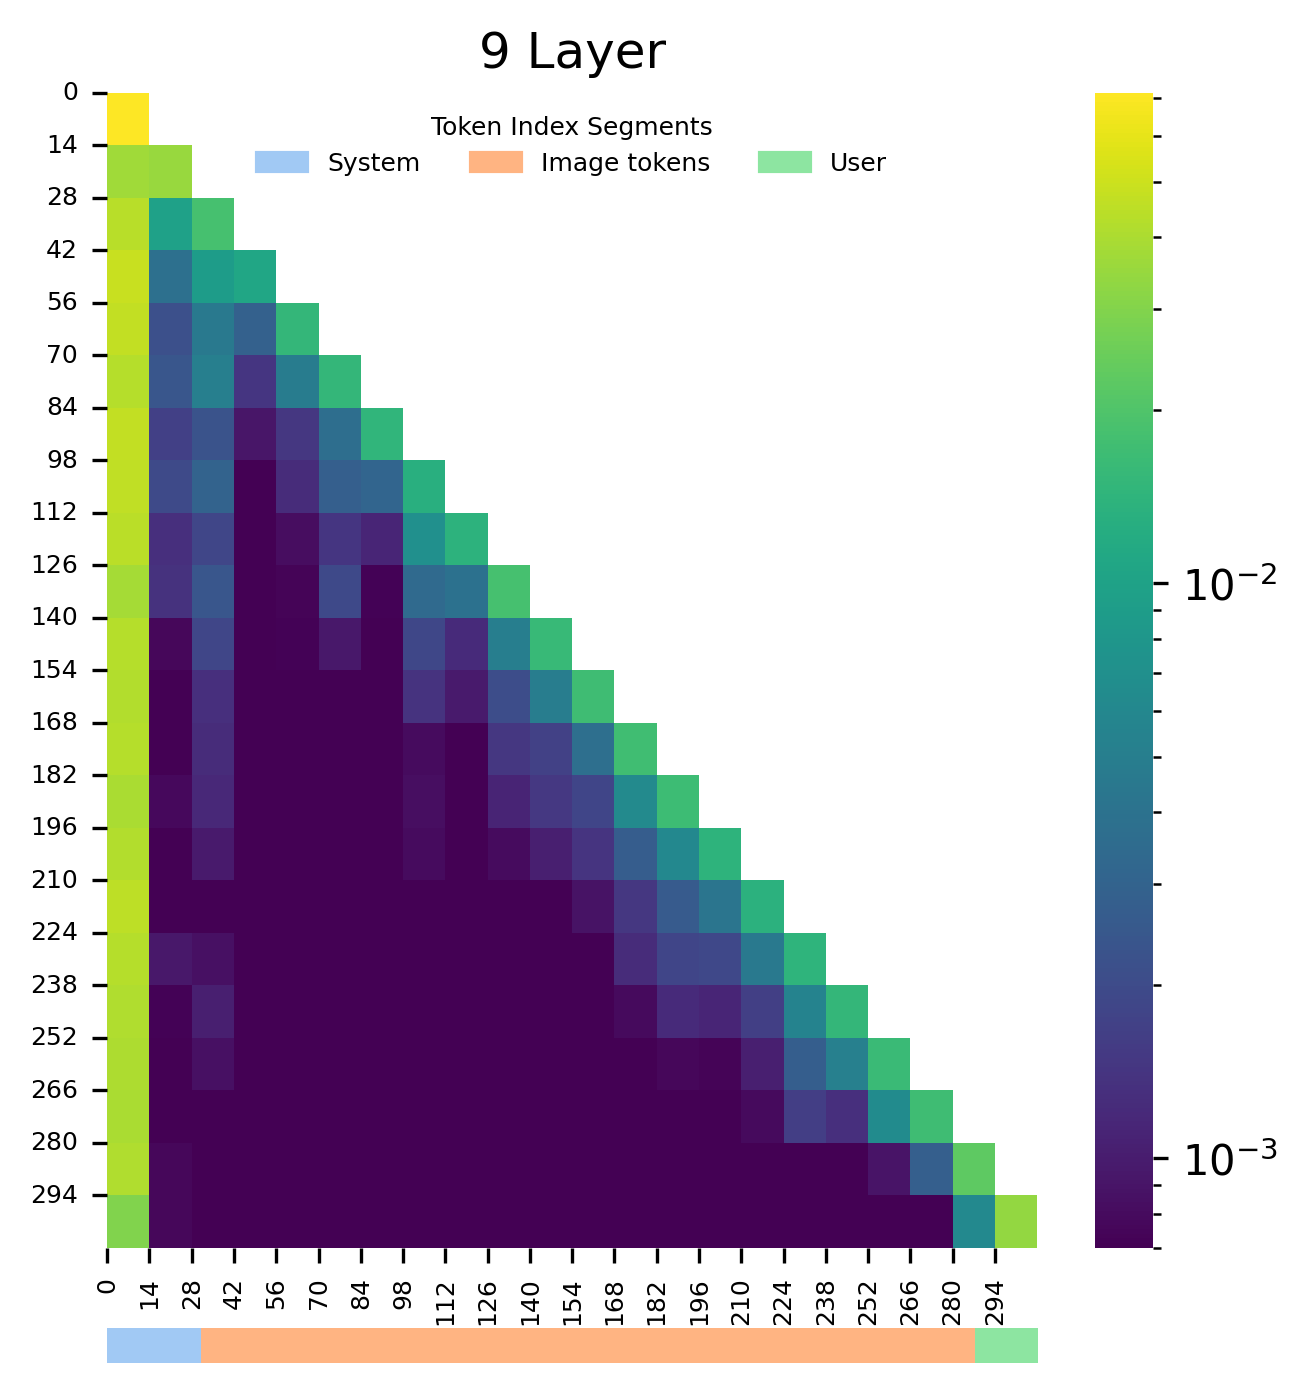

In [8]:
top5_attention, avg_attns = visualize_attention(embs[1], layer_index=8,
                                                sys_len=sys_len, img_len=img_len, usr_len=usr_len)

In [9]:

attns = np.stack(avg_attns, axis=0)
attns = torch.tensor(attns)
alpha_sys = attns[:,:,:sys_len].sum(dim=1)
alpha_img = attns[:,:,sys_len:sys_len+img_len].sum(dim=1)
alpha_usr = attns[:,:,sys_len+img_len:].sum(dim=1)

In [10]:
lambda_sys = alpha_sys.sum(dim=1)
lambda_img = alpha_img.sum(dim=1)
lambda_usr = alpha_usr.sum(dim=1)
lambda_sys, lambda_img, lambda_usr

(tensor([204.0376]), tensor([93.1429]), tensor([10.8074]))

In [11]:
eff_sys = lambda_sys / sys_len
eff_img = lambda_img / img_len
eff_usr = lambda_usr / usr_len
eff_sys, eff_img, eff_usr

(tensor([6.5819]), tensor([0.3638]), tensor([0.5146]))